Аналитика по данным системы SKUD за период 3-4 квартал 2022 года 

Импорт библиотек

In [1]:
import datetime as dt
import pandas as pd
import seaborn as sns # импорт библиотеки seaborn 
print(sns.__version__) # версия 
import matplotlib.pyplot as plt #модуль , отвечающий за визуализацию графиков 
%matplotlib inline

0.11.2


Считываем файл excel

In [2]:
data = pd.read_excel('3_4_kvartal.xlsx')
data.head() # вот что мы имеем

,Date,Object,Event,Zone,Employee
0,2022-07-01 07:49:00,ЦОД г. Усть-Каменогорск,Разрешен вход,Центральный вход,Пирогов Н. Н./ЕСЭДО/Главный инженер
1,2022-07-01 08:08:00,ЦОД г. Усть-Каменогорск,Разрешен вход,Центральный вход,Сулейменов А. С./Охрана/
2,2022-07-01 08:20:00,ЦОД г. Усть-Каменогорск,Разрешен вход,Центральный вход,Искакова М. М./СТО/Ведущий инженер
3,2022-07-01 08:32:00,ЦОД г. Усть-Каменогорск,Разрешен выход,Центральный вход,Пирогов Н. Н./ЕСЭДО/Главный инженер
4,2022-07-01 08:35:00,ЦОД г. Усть-Каменогорск,Разрешен вход,Центральный вход,Байжанова А./СТО/Инженер


Преобразуем тип столбца Date к типу Datetime

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20386 entries, 0 to 20385
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      20386 non-null  datetime64[ns]
 1   Object    20386 non-null  object        
 2   Event     20386 non-null  object        
 3   Zone      20386 non-null  object        
 4   Employee  20386 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 796.5+ KB


Преобразования типов данных, фильтрация

In [4]:
data['Day'] = data['Date'].dt.date # выделяем отдельно дату без времени
data = data[data['Zone']=='Центральный вход'] # Оставим события только по Центральному входу 
data = data[['Day', 'Date', 'Event', 'Employee']] # Оставим только нужны столбцы

data.head()

,Day,Date,Event,Employee
0,2022-07-01,2022-07-01 07:49:00,Разрешен вход,Пирогов Н. Н./ЕСЭДО/Главный инженер
1,2022-07-01,2022-07-01 08:08:00,Разрешен вход,Сулейменов А. С./Охрана/
2,2022-07-01,2022-07-01 08:20:00,Разрешен вход,Искакова М. М./СТО/Ведущий инженер
3,2022-07-01,2022-07-01 08:32:00,Разрешен выход,Пирогов Н. Н./ЕСЭДО/Главный инженер
4,2022-07-01,2022-07-01 08:35:00,Разрешен вход,Байжанова А./СТО/Инженер


Функция для обрезки лишней информации после ФИО, так как должности менялись и фамилии повторяются, также уберем опечатку по фамилии Скиданов

In [5]:
def cut_fio(fio):
    #fio = fio.replace('Сиданов А.', 'Скиданов А.')
    t = fio.find('.')
    return fio[:t+1]

data['Employee'] = data['Employee'].apply(cut_fio)   
data.head()

,Day,Date,Event,Employee
0,2022-07-01,2022-07-01 07:49:00,Разрешен вход,Пирогов Н.
1,2022-07-01,2022-07-01 08:08:00,Разрешен вход,Сулейменов А.
2,2022-07-01,2022-07-01 08:20:00,Разрешен вход,Искакова М.
3,2022-07-01,2022-07-01 08:32:00,Разрешен выход,Пирогов Н.
4,2022-07-01,2022-07-01 08:35:00,Разрешен вход,Байжанова А.


функция для формирования мини таблицы для каждого юзера за 1 день, где вход и выход сгруппированы и посчитан промежуток нахождения в офисе 

In [6]:
def create_tdelta_df(current_date, user_fio): # функция для формирования мини таблицы для каждого юзера за 1 день, где вход и выход сгруппированы и посчитан промежуток нахождения в офисе 
    user_tdelta_df = data[(data['Employee'] == user_fio )&(data['Day'] == current_date)]
    if user_tdelta_df.empty:
        return user_tdelta_df
    else:
        user_enters = user_tdelta_df[user_tdelta_df['Event'] == 'Разрешен вход']
        user_enters = user_enters[['Date', 'Employee', 'Day']].rename(columns={"Date": "Enter_time"})
        user_exits = user_tdelta_df[user_tdelta_df['Event'] == 'Разрешен выход']
        user_exits = user_exits[['Date', 'Employee', 'Day']].rename(columns={"Date": "Exit_time"})
        k = 1
        for index, row in user_enters.iterrows():
            user_enters.loc[index,'N_enter'] =  k
            k += 1   
        r = 1
        for index, row in user_exits.iterrows():
            user_exits.loc[index,'N_enter'] =  r
            r += 1 
        user_tdelta_df = user_enters.merge(        # объединяем датафреймы по полю N_enter 
        user_exits, on="N_enter", how="inner"
        )
        user_tdelta_df = user_tdelta_df[['Day_x', 'Employee_x', 'N_enter', 'Enter_time', 'Exit_time']].rename(columns={'Day_x': 'Day', 'Employee_x': 'Employee'})
        user_tdelta_df['Timedelta'] = user_tdelta_df['Exit_time'] - user_tdelta_df['Enter_time']
        return user_tdelta_df

Формируем пустой DataFrame для дальнейшего заполнения 

In [7]:
tdelta_df = pd.DataFrame({'Day': [],
                     'Employee': [],
                     'N_enter': [],
                     'Enter_time': [],
                     'Exit_time': [],
                     'Timedelta': [],
                     'Lunch_tdelta':[]
                     })
test_tdelta = create_tdelta_df(dt.date(2022, 7, 25), 'Аимжанова А.') # проба функции
test_tdelta


,Day,Employee,N_enter,Enter_time,Exit_time,Timedelta
0,2022-07-25,Аимжанова А.,1.0,2022-07-25 09:06:00,2022-07-25 13:31:00,0 days 04:25:00
1,2022-07-25,Аимжанова А.,2.0,2022-07-25 14:18:00,2022-07-25 18:37:00,0 days 04:19:00


Формируем списки дат событий и списки сотрудников для дальнейшего формирования нового Датафрейма

In [8]:
dates = sorted(data['Day'].unique().tolist())
users = data['Employee'].unique().tolist()
# исключаем из списка бывших сотрудников, водителей, охранников 
users = [user for user in users if user not in ['Смирнов А.', 'Сергеев О.', 'Семенов М.', 'Сулейменов А.', 'Асланбек Е.', 'Федорова Л.', 'Мезенцев А.', 'Плахов А.', 'Энгель Г.', 'Михайленко Е.']]
print(users)

['Пирогов Н.', 'Искакова М.', 'Байжанова А.', 'Жанабаева М.', 'Сакенов А.', 'Куликов В.', 'Михайлов И.', 'Демидов А.', 'Иванов И.', 'Бурумбаева Г.', 'Икманова С.', 'Пинегин Е.', 'Пирманов А.', 'Миронова Л.', 'Морозова Е.', 'Резник А.', 'Бунин Н.', 'Сайлаубек Е.', 'Серегин Д.', 'Скакова С.', 'Минаев И.', 'Листьева Н.', 'Ринатов М.', 'Медетов С.', 'Хугаев О.', 'Петров Е.', 'Сейтказин С.', 'Рахманов С.', 'Сидоров А.', 'Акимканова А.', 'Олейник Д.', 'Романов Р.', 'Печенкин Р.', 'Апполонов И.', 'Денисов Д.', 'Гараев А.', 'Еламанулы Д.', 'Асланова А.', 'Максимов А.', 'Аимжанова А.', 'Овсиенко И.', 'Арыстанбеков Е.', 'Магзумов А.', 'Хромов П.', 'Оспанова А.', 'Николаева Л.', 'Нурбеков К.']


Формируем новую таблицу с временными промежутками, склеивая мини таблицы по каждому пользователю за каждый рабочий день  

In [9]:
for date in dates: # формируем новую таблицу с временными промежутками 
    for user in users:
        df = create_tdelta_df(date, user) # вызываем функцию по формированию timedelta
        if df.empty:
            continue
        else:
            yyyy = date.year #выделяем год из взятой даты
            mm = date.month #выделяем месяц
            dd = date.day #выделяем день
            lunch_time_start = dt.datetime(yyyy, mm, dd, 13, 0, 0) # собираем датувремя начала обеденного перерыва на текущий день 
            lunch_time_end = dt.datetime(yyyy, mm, dd, 14, 0, 0) # собираем датувремя конца обеденного перерыва
            for index, row in df.iterrows(): #Проходимся по всем промежуткам времени  
                enter_time = df.loc[index,'Enter_time'] # время входа 
                exit_time = df.loc[index,'Exit_time'] # время выхода 
                #print(f'Enter time: {enter_time}  Exit time: {exit_time}')
                # если время входа ВО время обед-го перерыва           и    время выхода ВО время обед перерыва
                if (lunch_time_start <= enter_time <= lunch_time_end) and  (lunch_time_start <= exit_time <= lunch_time_end):
                    df.loc[index,'Lunch_tdelta'] = exit_time - enter_time # то этот промежуток времени относим полдностью к lunch_time
                  # если время входа ВО время обед-го перерыва   и    время выхода НЕ во время обед перерыва
                elif (lunch_time_start <= enter_time <= lunch_time_end) and not(lunch_time_start <= exit_time <= lunch_time_end):
                    df.loc[index,'Lunch_tdelta'] = lunch_time_end - enter_time # то lunch_time считаем так 
                   # если время входа НЕ во время обед-го перерыва   и    время выхода ВО время обед перерыва  
                elif not(lunch_time_start <= enter_time <= lunch_time_end) and (lunch_time_start <= exit_time <= lunch_time_end):
                    df.loc[index,'Lunch_tdelta'] = exit_time - lunch_time_start 
                    # если время входа ДО обед-го перерыва   и    время выхода ПОСЛЕ обед перерыва  
                elif enter_time <= lunch_time_start and exit_time >= lunch_time_end:
                    df.loc[index,'Lunch_tdelta'] = dt.timedelta(0, hours = 1) # то в lunch_time записываем 1 час 
                else:
                    df.loc[index,'Lunch_tdelta'] = dt.timedelta(0) # во всех остальных случаях записываем 0 в lunch_time



            tdelta_df = pd.concat([tdelta_df, df], sort=False, axis=0) # приклеиваем эту таблицу к tdelta_df
    
tdelta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8747 entries, 0 to 2
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Day           8747 non-null   object 
 1   Employee      8747 non-null   object 
 2   N_enter       8747 non-null   float64
 3   Enter_time    8747 non-null   object 
 4   Exit_time     8747 non-null   object 
 5   Timedelta     8747 non-null   object 
 6   Lunch_tdelta  8747 non-null   object 
dtypes: float64(1), object(6)
memory usage: 546.7+ KB


        Вот что у нас получилось 
    N-enter - номер входа сотрудника на объект 
    Enter_time - время входа на объект
    Exit_time - время выхода 
    Timedelta - временной промежуток нахождения на объекте 
    Lunch_tdelta - врем промежуток нахождения на объекте в обеденное время



In [10]:
tdelta_df.head()

,Day,Employee,N_enter,Enter_time,Exit_time,Timedelta,Lunch_tdelta
0,2022-07-01,Пирогов Н.,1.0,2022-07-01 07:49:00,2022-07-01 08:32:00,0 days 00:43:00,0 days 00:00:00
1,2022-07-01,Пирогов Н.,2.0,2022-07-01 08:43:00,2022-07-01 09:58:00,0 days 01:15:00,0 days 00:00:00
2,2022-07-01,Пирогов Н.,3.0,2022-07-01 10:04:00,2022-07-01 10:30:00,0 days 00:26:00,0 days 00:00:00
3,2022-07-01,Пирогов Н.,4.0,2022-07-01 10:39:00,2022-07-01 11:23:00,0 days 00:44:00,0 days 00:00:00
4,2022-07-01,Пирогов Н.,5.0,2022-07-01 11:29:00,2022-07-01 12:20:00,0 days 00:51:00,0 days 00:00:00


Преобразуем столбцы с датами к нужным типам 

In [11]:
tdelta_df['Day'] = pd.to_datetime(tdelta_df['Day'])
tdelta_df['Day'] = tdelta_df['Day'].dt.date
tdelta_df['Enter_time'] = pd.to_datetime(tdelta_df['Enter_time'])
tdelta_df['Exit_time'] = pd.to_datetime(tdelta_df['Exit_time'])
tdelta_df['Timedelta'] = pd.to_timedelta(tdelta_df['Timedelta'])
tdelta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8747 entries, 0 to 2
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Day           8747 non-null   object         
 1   Employee      8747 non-null   object         
 2   N_enter       8747 non-null   float64        
 3   Enter_time    8747 non-null   datetime64[ns] 
 4   Exit_time     8747 non-null   datetime64[ns] 
 5   Timedelta     8747 non-null   timedelta64[ns]
 6   Lunch_tdelta  8747 non-null   object         
dtypes: datetime64[ns](2), float64(1), object(3), timedelta64[ns](1)
memory usage: 546.7+ KB


Проверим не получилось ли у нас отрицательных значений в timedelta

In [12]:
wrong = tdelta_df[tdelta_df['Timedelta'] < dt.timedelta(0)] #Проверка на ошибки
wrong['Employee'].unique()

array([], dtype=object)

In [13]:
hours_df = tdelta_df[(tdelta_df['Employee'] == 'Скакова С.') & (tdelta_df['Day'] == dt.date(2022,7,5))] # проверяем как фильтруются данные 
hours_df.head()

,Day,Employee,N_enter,Enter_time,Exit_time,Timedelta,Lunch_tdelta
0,2022-07-05,Скакова С.,1.0,2022-07-05 09:00:00,2022-07-05 13:04:00,0 days 04:04:00,0 days 00:04:00
1,2022-07-05,Скакова С.,2.0,2022-07-05 13:11:00,2022-07-05 13:34:00,0 days 00:23:00,0 days 00:23:00
2,2022-07-05,Скакова С.,3.0,2022-07-05 14:09:00,2022-07-05 17:35:00,0 days 03:26:00,0 days 00:00:00


In [14]:
early_exit = dt.datetime(2022, 7, 5, 18, 0, 0) - hours_df[hours_df['N_enter']==hours_df['N_enter'].max()]['Exit_time'] #пробуем вычислить ранний уход с рабочего места 
early_exit[hours_df['N_enter'].max()-1]

Timedelta('0 days 00:25:00')

In [16]:
def summ_hours_df(current_date, user_fio): # функция для формирования кортежа с суммой часов проведенных в офисе 
    hours_df = tdelta_df[(tdelta_df['Employee'] == user_fio) & (tdelta_df['Day'] == current_date)]
    per_day = tuple()
   
    if hours_df.empty:
        return per_day
    else:
        first_enter_time = hours_df[hours_df['N_enter']==1.0]['Enter_time']
        yyyy = current_date.year
        mm = current_date.month
        dd = current_date.day
        last = hours_df['N_enter'].max()
        last_exit_time = hours_df[hours_df['N_enter']==last]['Exit_time']
        last_exit_time = last_exit_time[round(last-1)]

        if user_fio == 'Петров Е.':
            late_time = first_enter_time - dt.datetime(yyyy, mm, dd, 10, 0, 0)
            early_exit = dt.datetime(yyyy, mm, dd, 19, 0, 0) - last_exit_time
        elif user_fio == 'Жанабаева М.':
            late_time = first_enter_time - dt.datetime(yyyy, mm, dd, 8, 30, 0)
            early_exit = dt.datetime(yyyy, mm, dd, 17, 30, 0) - last_exit_time
        else:    
            late_time = first_enter_time - dt.datetime(yyyy, mm, dd, 9, 0, 0)
            early_exit = dt.datetime(yyyy, mm, dd, 18, 0, 0) - last_exit_time

        #early_exit = early_exit[last-1]
        tdelta = hours_df.groupby(by='Day')['Timedelta'].agg('sum')
        lunch_tdelta = hours_df.groupby(by='Day')['Lunch_tdelta'].agg('sum')
        c = user_fio.find(' ')

        if user_fio[c-1] in ['а', 'я', 'р']: #если фамилия заканчивается на -а, -я, -р , то в переменную sex записываем Жен, иначе Муж
            gender = 'Female'
        else:
            gender = 'Male'
                                                                                                                    #отнимаем обед время от общего времени нахождения в офисе 
        per_day = (current_date, user_fio, gender, first_enter_time[0], last_exit_time, late_time[0], early_exit, last, tdelta[current_date]- lunch_tdelta[current_date])
        return per_day

Формируем список с кортежами для дальнейшего создания новой таблицы 

In [17]:
hours_list = [] 
for date in dates:
    for user in users:
        tpl = summ_hours_df(date, user)
        if tpl:
            hours_list.append(tpl)
            #hours_list
        else:
            continue

    Формируем новую таблицу на базе списка с кортежами
    Day - дата
    Employee - сотрудник
    столбец Gender - пол,
    First_enter_time - время первого входа 
    Last_exit_time - время последнего выхода 
    Late_time - время на которое опоздал сотрудник с утра 
    Early_exit - время на которое сотрудник раньше ушёл с рабочего места 
    Exit_cnt - Количество входов выходов из здания 
    Timedelta - промежуток времени нахождения на объекте 



In [18]:
hours_df = pd.DataFrame(hours_list, columns=['Day', 'Employee', 'Gender', 'First_enter_time', 'Last_exit_time', 'Late_time', 'Early_exit', 'Exit_cnt', 'Timedelta']) 
hours_df.head(10)

,Day,Employee,Gender,First_enter_time,Last_exit_time,Late_time,Early_exit,Exit_cnt,Timedelta
0,2022-07-01,Пирогов Н.,Male,2022-07-01 07:49:00,2022-07-01 18:12:00,-1 days +22:49:00,-1 days +23:48:00,14.0,0 days 07:57:00
1,2022-07-01,Искакова М.,Female,2022-07-01 08:20:00,2022-07-01 17:07:00,-1 days +23:20:00,0 days 00:53:00,3.0,0 days 07:32:00
2,2022-07-01,Байжанова А.,Female,2022-07-01 08:35:00,2022-07-01 18:07:00,-1 days +23:35:00,-1 days +23:53:00,3.0,0 days 08:18:00
3,2022-07-01,Жанабаева М.,Female,2022-07-01 08:39:00,2022-07-01 17:37:00,0 days 00:09:00,-1 days +23:53:00,2.0,0 days 07:41:00
4,2022-07-01,Сакенов А.,Male,2022-07-01 08:43:00,2022-07-01 18:16:00,-1 days +23:43:00,-1 days +23:44:00,3.0,0 days 08:17:00
5,2022-07-01,Куликов В.,Male,2022-07-01 08:48:00,2022-07-01 18:09:00,-1 days +23:48:00,-1 days +23:51:00,2.0,0 days 08:21:00
6,2022-07-01,Михайлов И.,Male,2022-07-01 08:53:00,2022-07-01 17:08:00,-1 days +23:53:00,0 days 00:52:00,2.0,0 days 07:15:00
7,2022-07-01,Демидов А.,Male,2022-07-01 08:54:00,2022-07-01 18:45:00,-1 days +23:54:00,-1 days +23:15:00,2.0,0 days 08:19:00
8,2022-07-01,Иванов И.,Male,2022-07-01 08:54:00,2022-07-01 18:18:00,-1 days +23:54:00,-1 days +23:42:00,3.0,0 days 07:28:00
9,2022-07-01,Бурумбаева Г.,Female,2022-07-01 08:55:00,2022-07-01 18:09:00,-1 days +23:55:00,-1 days +23:51:00,2.0,0 days 07:59:00


Оставим только положительные значение во временных промежутках

In [19]:
hours_df['Late_time'] = hours_df[(dt.timedelta(hours=0) < hours_df['Late_time']) & (hours_df['Late_time']< dt.timedelta(minutes=31))]['Late_time'] #Оставим только положительные значения до 30 мин 
hours_df['Early_exit'] = hours_df[(dt.timedelta(hours=0) < hours_df['Early_exit']) & (hours_df['Early_exit'] < dt.timedelta(minutes=31))]['Early_exit'] #Оставим только положительные значения до 30 мин 
hours_df['Day'] = pd.to_datetime(hours_df['Day']) # приводим к типу
hours_df['Month'] = hours_df['Day'].dt.month # добавим столбец с месяцем 
hours_df[hours_df['Late_time'].notnull()]

,Day,Employee,Gender,First_enter_time,Last_exit_time,Late_time,Early_exit,Exit_cnt,Timedelta,Month
3,2022-07-01,Жанабаева М.,Female,2022-07-01 08:39:00,2022-07-01 17:37:00,0 days 00:09:00,NaT,2.0,0 days 07:41:00,7
18,2022-07-01,Серегин Д.,Male,2022-07-01 09:01:00,2022-07-01 18:06:00,0 days 00:01:00,NaT,2.0,0 days 07:37:00,7
20,2022-07-01,Минаев И.,Male,2022-07-01 09:06:00,2022-07-01 11:52:00,0 days 00:06:00,NaT,2.0,0 days 02:40:00,7
21,2022-07-01,Листьева Н.,Female,2022-07-01 09:07:00,2022-07-01 18:11:00,0 days 00:07:00,NaT,2.0,0 days 08:04:00,7
22,2022-07-01,Ринатов М.,Male,2022-07-01 09:07:00,2022-07-01 18:06:00,0 days 00:07:00,NaT,4.0,0 days 07:25:00,7
...,...,...,...,...,...,...,...,...,...,...
2966,2022-12-14,Петров Е.,Male,2022-12-14 10:28:00,2022-12-14 19:20:00,0 days 00:28:00,NaT,14.0,0 days 06:23:00,12
2967,2022-12-14,Рахманов С.,Male,2022-12-14 09:03:00,2022-12-14 13:06:00,0 days 00:03:00,NaT,1.0,0 days 03:57:00,12
2970,2022-12-14,Асланова А.,Female,2022-12-14 09:08:00,2022-12-14 18:02:00,0 days 00:08:00,NaT,2.0,0 days 07:54:00,12
2972,2022-12-14,Овсиенко И.,Male,2022-12-14 09:04:00,2022-12-14 18:16:00,0 days 00:04:00,NaT,2.0,0 days 08:12:00,12


In [20]:
hours_df['First_enter_time'] = hours_df['First_enter_time'].dt.time # 
hours_df['Last_exit_time'] = hours_df['Last_exit_time'].dt.time
hours_df.head()

,Day,Employee,Gender,First_enter_time,Last_exit_time,Late_time,Early_exit,Exit_cnt,Timedelta,Month
0,2022-07-01,Пирогов Н.,Male,07:49:00,18:12:00,NaT,NaT,14.0,0 days 07:57:00,7
1,2022-07-01,Искакова М.,Female,08:20:00,17:07:00,NaT,NaT,3.0,0 days 07:32:00,7
2,2022-07-01,Байжанова А.,Female,08:35:00,18:07:00,NaT,NaT,3.0,0 days 08:18:00,7
3,2022-07-01,Жанабаева М.,Female,08:39:00,17:37:00,0 days 00:09:00,NaT,2.0,0 days 07:41:00,7
4,2022-07-01,Сакенов А.,Male,08:43:00,18:16:00,NaT,NaT,3.0,0 days 08:17:00,7


Переводим значения Timedelta в float - числовые, для возможности построения графиков 

In [21]:
hours_df['Late_time'] = hours_df['Late_time'].apply(lambda x: x.total_seconds()/60) # переводим timedelta в int - минуты 
hours_df['Early_exit'] = hours_df['Early_exit'].apply(lambda x: x.total_seconds()/60) 
hours_df['Timedelta'] = hours_df['Timedelta'].apply(lambda x: round(x.total_seconds()/3600, 2)) # переводим timedelta в int - часы 
hours_df = hours_df.rename(columns={'Late_time': 'Late_min', 'Timedelta': 'Timedelta_hour'})
hours_df = hours_df.fillna(0)
hours_df.head()


,Day,Employee,Gender,First_enter_time,Last_exit_time,Late_min,Early_exit,Exit_cnt,Timedelta_hour,Month
0,2022-07-01,Пирогов Н.,Male,07:49:00,18:12:00,0.0,0.0,14.0,7.95,7
1,2022-07-01,Искакова М.,Female,08:20:00,17:07:00,0.0,0.0,3.0,7.53,7
2,2022-07-01,Байжанова А.,Female,08:35:00,18:07:00,0.0,0.0,3.0,8.30,7
3,2022-07-01,Жанабаева М.,Female,08:39:00,17:37:00,9.0,0.0,2.0,7.68,7
4,2022-07-01,Сакенов А.,Male,08:43:00,18:16:00,0.0,0.0,3.0,8.28,7


In [22]:
hours_df.to_csv('hours_df.csv')

Выявляем работников с опозданиями более 10 мин, сортируем по убыванию значения и на основе расчетов строим график 

In [23]:
laters = hours_df[hours_df['Late_min']>5][['Employee', 'Late_min']].groupby(by='Employee').agg('count').sort_values(by='Late_min', ascending=False)

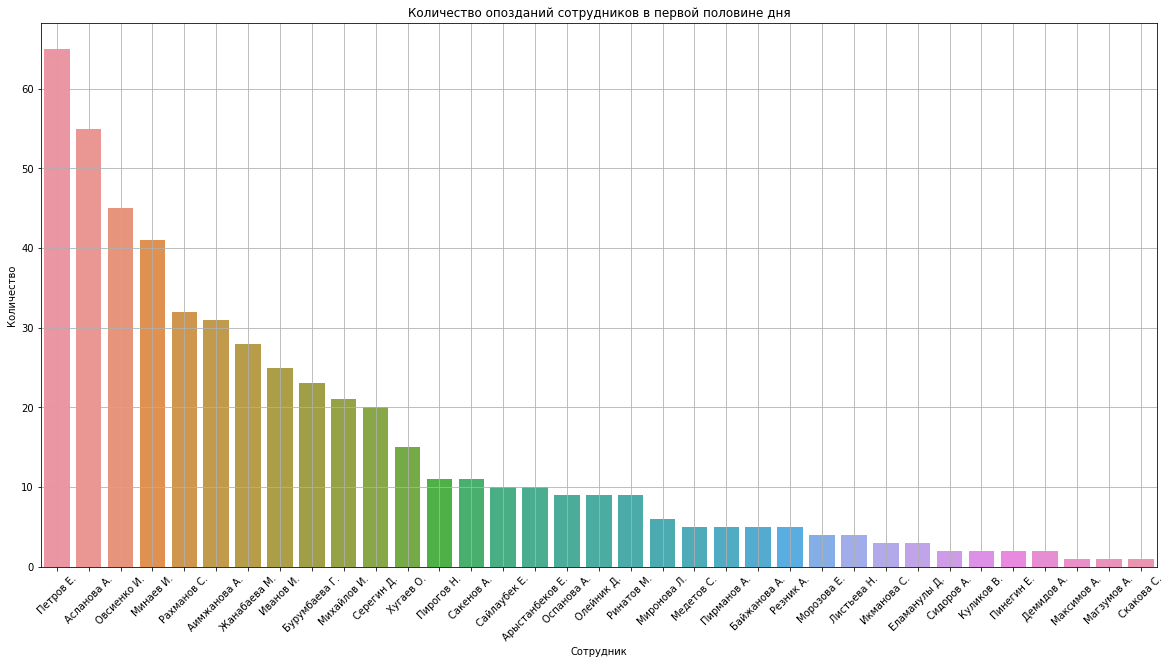

In [24]:
fig = plt.figure(figsize=(20, 10))
barplot = sns.barplot(
    data=laters,
    y='Late_min',
    x=laters.index   
)
barplot.set_title('Количество опозданий сотрудников в первой половине дня');
barplot.set_xlabel('Сотрудник');
barplot.set_ylabel('Количество');
plt.xticks(rotation = 45)
barplot.grid()


In [25]:
local_users = [user for user in users if user not in ['Нурбеков К.', 'Хохлов Р.', 'Печенкин Р.', 'Махсутов А.', 'Плехов А.', 'Болатбек Е.', 'Хижняк П.', 'Григорьев И.', 'Зацепин Д.', 'Галлямов А.', 'Максимович Е.', 'Никишина Л.']]
mean_late = hours_df[(hours_df['Employee'].isin(local_users))][['Employee', 'Late_min']].groupby(by='Employee').agg('mean').sort_values(by='Late_min', ascending=False)


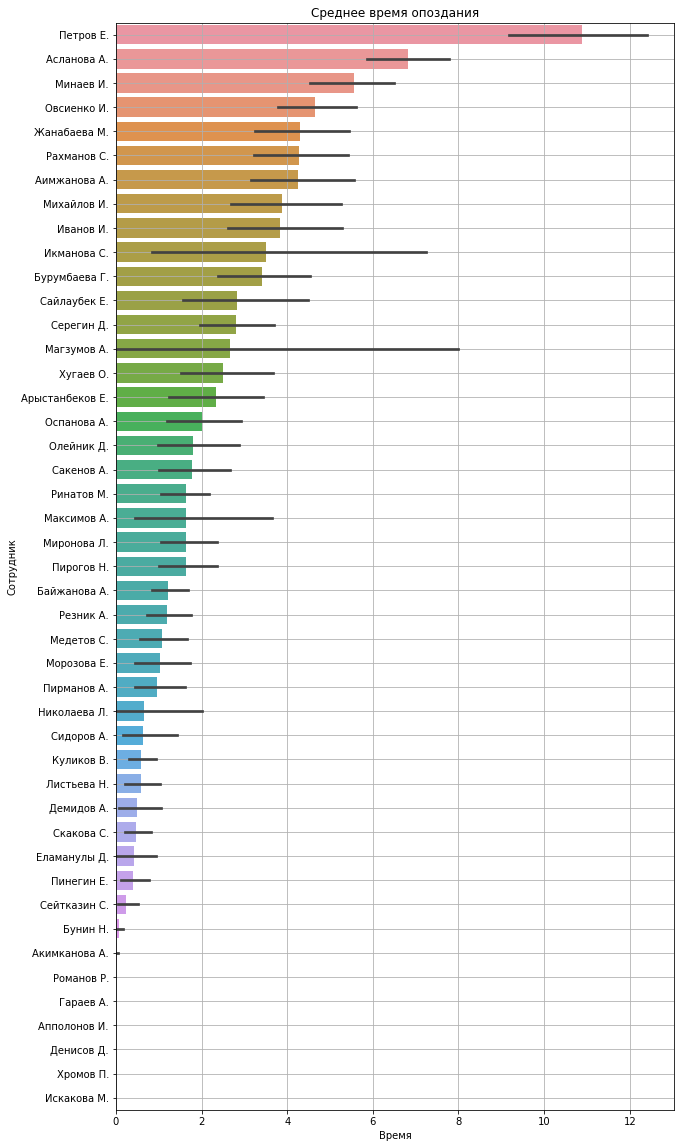

In [26]:
fig = plt.figure(figsize=(10, 20))
barplot = sns.barplot(
    data=hours_df,
    y='Employee',
    x='Late_min',
    orient='h',
    order = mean_late.index
    #width=0.9
)
barplot.set_title('Среднее время опоздания');
barplot.set_xlabel('Время');
barplot.set_ylabel('Сотрудник');
barplot.grid()

Выявим сотрудников злоупотребляющих ранним уходом с рабочего места , для этого отсортируем по убыванию количества случаев раннего ухода  и на основе расчета построим barplot

In [27]:
earliers = hours_df[hours_df['Early_exit']>0][['Employee', 'Early_exit']].groupby(by='Employee').agg('count').sort_values(by='Early_exit', ascending=False)


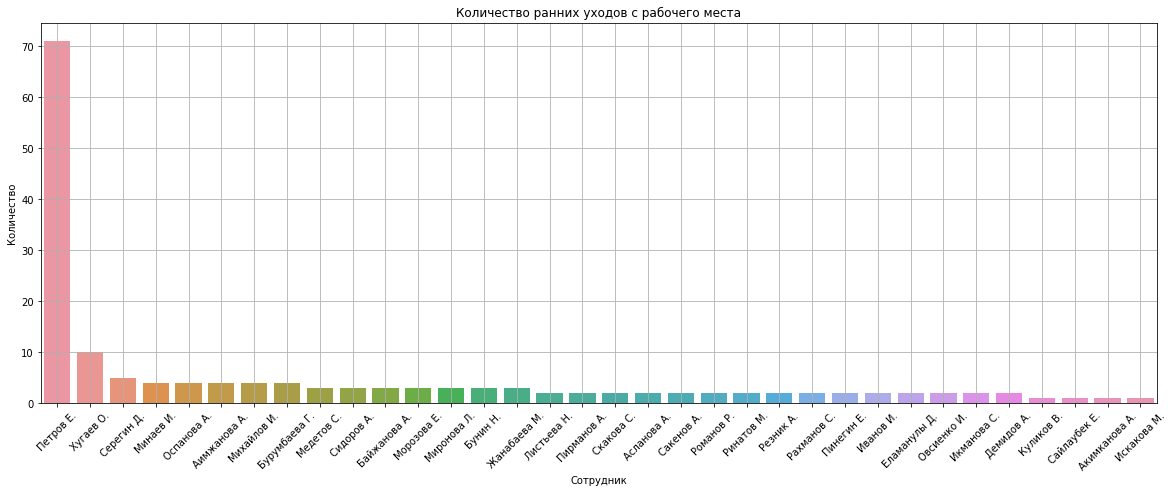

In [28]:
fig = plt.figure(figsize=(20, 7))
barplot = sns.barplot(
    data = earliers,
    y ='Early_exit',
    x =earliers.index   
)
barplot.set_title('Количество ранних уходов с рабочего места');
barplot.set_xlabel('Сотрудник');
barplot.set_ylabel('Количество');
plt.xticks(rotation = 45)
barplot.grid()

Построим коробочковую диаграмму для определения статистики по времени нахождения в офисе каждого сотрудника 

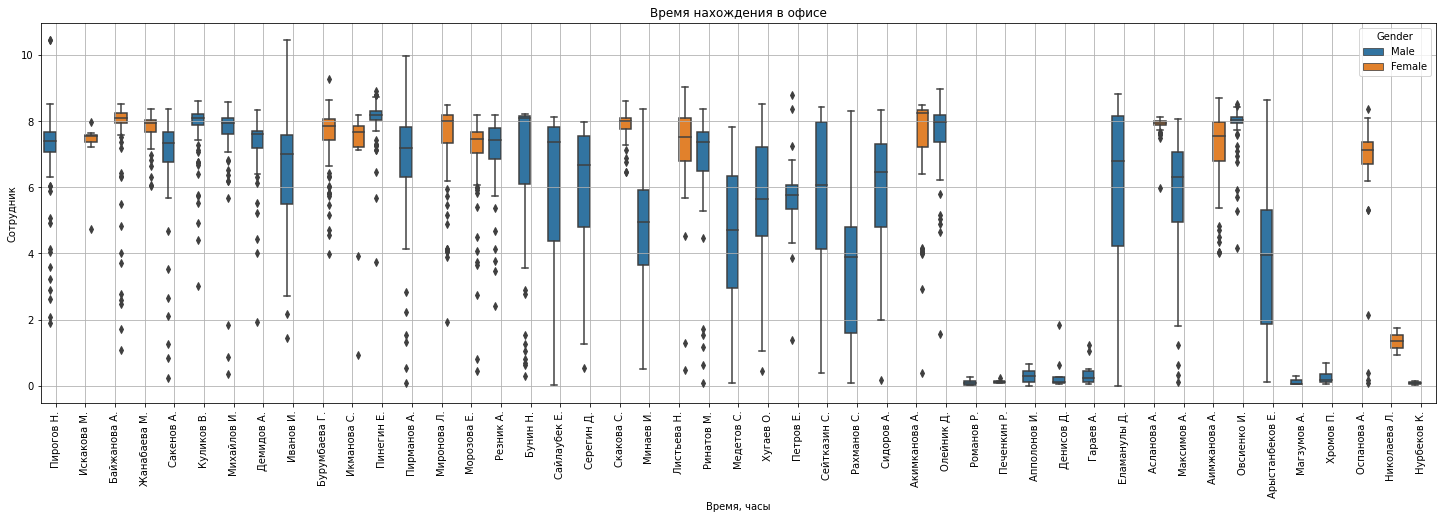

In [29]:
fig = plt.figure(figsize=(25, 7))
boxplot = sns.boxplot(
    data=hours_df,
    x='Employee',
    y='Timedelta_hour',
    #orient='h',
    hue='Gender'
)
boxplot.set_title('Время нахождения в офисе');
boxplot.set_xlabel('Время, часы');
boxplot.set_ylabel('Сотрудник');
plt.xticks(rotation = 90)
boxplot.grid()

Построим barplot для определения среднего времени проведенного в офисе отдельно для местных сотрудников 

In [33]:
local_users = [user for user in users if user not in ['Нурбеков К.', 'Романов Р.', 'Печенкин Р.', 'Магзумов А.', 'Плехов А.', 'Болатбек Е.', 'Хромов П.', 'Апполонов И.', 'Денисов Д.', 'Гараев А.', 'Максимович Е.', 'Николаева Л.']]

In [34]:
local_hours = hours_df[hours_df['Employee'].isin(local_users)][['Employee', 'Timedelta_hour']].groupby(by='Employee').agg('mean').sort_values(by='Timedelta_hour')


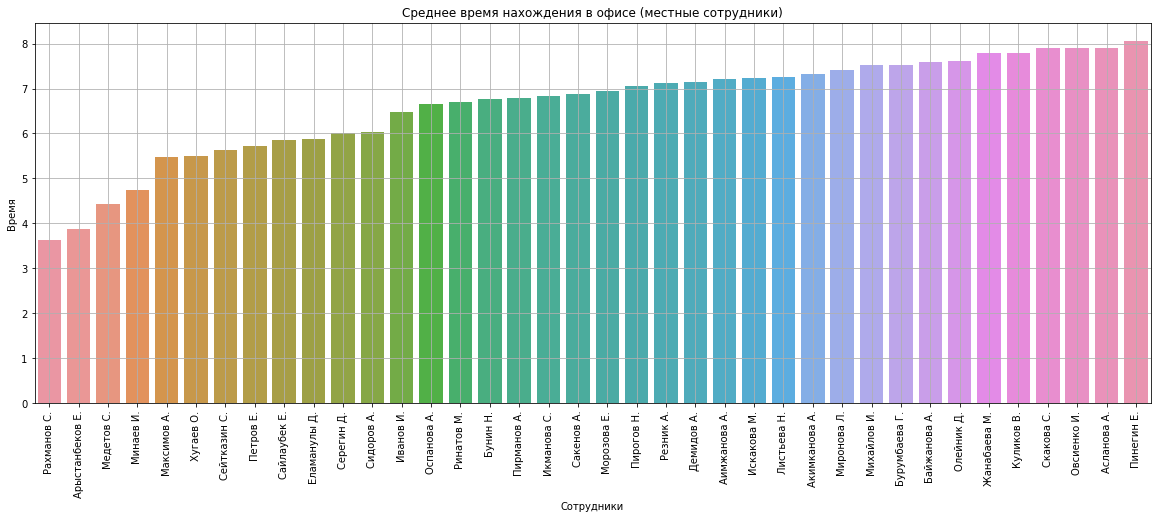

In [35]:
fig = plt.figure(figsize=(20, 7))
boxplot = sns.barplot(
    data=local_hours,
    y='Timedelta_hour',
    x=local_hours.index
    #order=local_hours.sort_values('Timedelta_hour', ascending=False).Staff,
    #hue='Gender'
    #width=0.9
)
boxplot.set_title('Среднее время нахождения в офисе (местные сотрудники)');
boxplot.set_xlabel('Сотрудники');
boxplot.set_ylabel('Время');
plt.xticks(rotation=90)
boxplot.grid()

Выявим сотрудников часто покидающих рабочее место 

In [36]:
result = hours_df[hours_df['Employee'].isin(local_users)][['Employee','Exit_cnt']].groupby(by='Employee').agg('mean').sort_values(by='Exit_cnt', ascending=False)


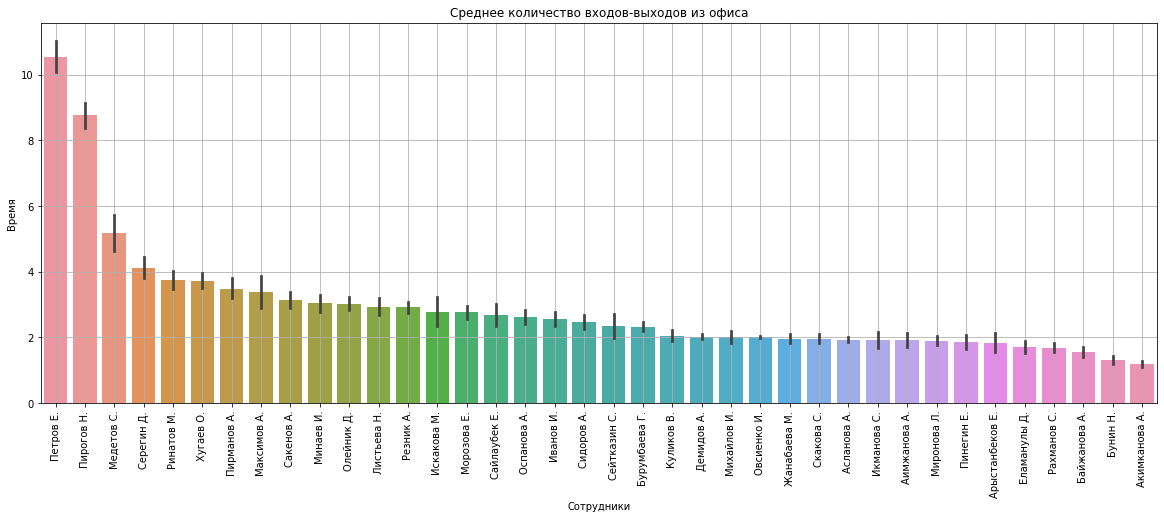

In [37]:
fig = plt.figure(figsize=(20, 7))
boxplot = sns.barplot(
    data= hours_df[hours_df['Employee'].isin(local_users)],
    y='Exit_cnt',
    x='Employee',
    order= result.index#,
    #hue='Gender'

)
boxplot.set_title('Среднее количество входов-выходов из офиса');
boxplot.set_xlabel('Сотрудники');
boxplot.set_ylabel('Время');
plt.xticks(rotation=90)
boxplot.grid()

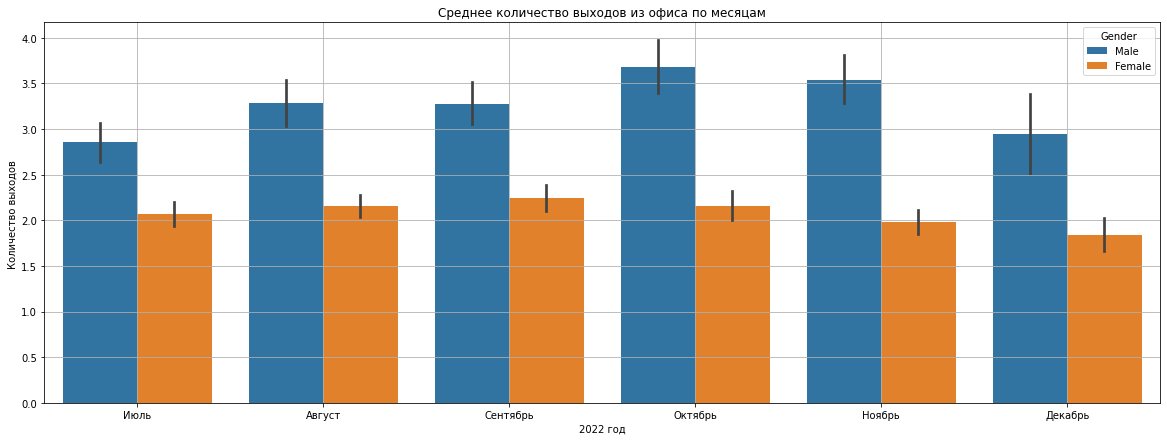

In [38]:
fig = plt.figure(figsize=(20, 7))
boxplot = sns.barplot(
    data=hours_df,
    y= 'Exit_cnt',
    x= 'Month',
    hue='Gender'
    #width=0.9
)
boxplot.set_title('Среднее количество выходов из офиса по месяцам');
boxplot.set_xlabel('2022 год');
boxplot.set_ylabel('Количество выходов ');
boxplot.set_xticklabels(['Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
plt.xticks(rotation=0)
boxplot.grid()